# Lab 4 - Linear models

We focus on models in the form 

$$ y ~ \mathrm{Normal}(\alpha+X\beta,\sigma) $$

or in generalized form (generalized linear models)

$$ f(y) ~ \mathrm{Normal}(\alpha+X\beta,\sigma) $$

where $f(y)$ is a link function, for example - logit.


In [25]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd
from seaborn import jointplot

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [3]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


#### Task 1. Prior predictive checks

1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors
4. Check if observed data is possible to obtain using priors.

In [5]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [6]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [27]:
data = fit.draws_pd()
data

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma,height
0,-896.475,0.989141,0.879734,3.0,7.0,0.0,898.035,155.103,8.10072,151.389
1,-895.714,0.996108,0.879734,2.0,3.0,0.0,896.915,154.992,7.57395,153.867
2,-896.343,0.895673,0.879734,2.0,3.0,0.0,897.119,155.228,7.90630,146.875
3,-895.404,0.991829,0.879734,2.0,3.0,0.0,896.577,154.815,7.56726,154.424
4,-895.849,0.841095,0.879734,2.0,3.0,0.0,896.865,154.890,8.04910,147.182
...,...,...,...,...,...,...,...,...,...,...
3995,-895.627,1.000000,0.838787,2.0,3.0,0.0,896.279,154.803,8.01422,144.451
3996,-895.727,0.982861,0.838787,1.0,1.0,0.0,895.799,154.755,8.05962,145.407
3997,-895.745,0.978395,0.838787,3.0,7.0,0.0,896.465,155.072,7.80211,165.997
3998,-895.541,0.984102,0.838787,2.0,7.0,0.0,896.007,154.218,7.76397,147.339


In [10]:
mu = fit.stan_variable('mu')
sigma = fit.stan_variable('sigma')
sim_height = fit.stan_variable('height')

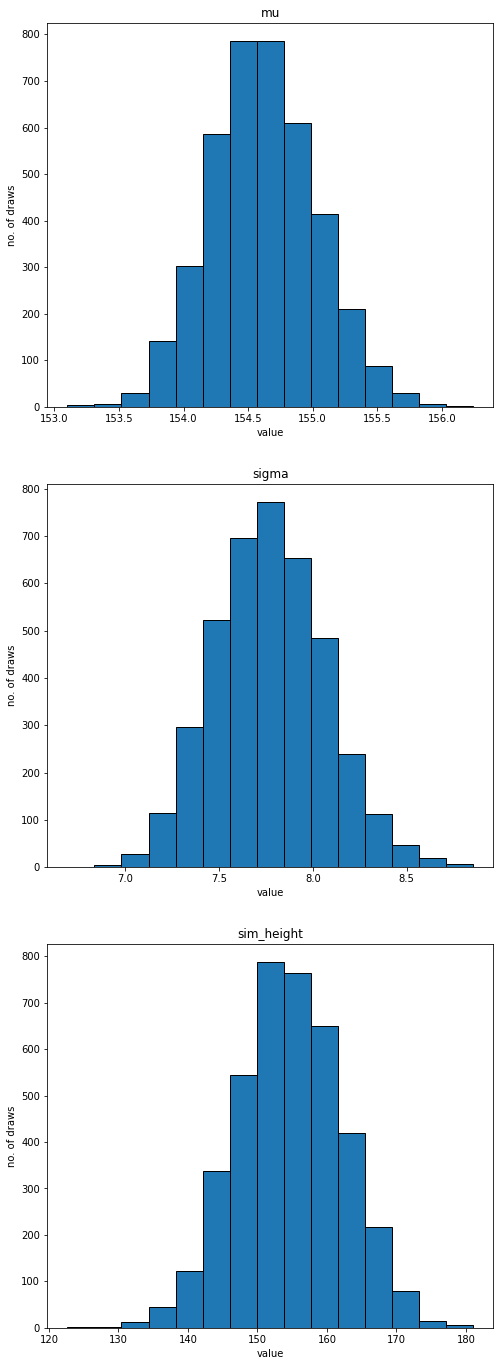

In [23]:
fig, axes = plt.subplots(3, 1, figsize = (8, 24))
axes[0].hist(mu, bins = 15, edgecolor='k')
axes[0].set_title('mu')
axes[0].set_xlabel('value')
axes[0].set_ylabel('no. of draws')
axes[1].hist(sigma, bins = 15, edgecolor='k')
axes[1].set_title('sigma')
axes[1].set_xlabel('value')
axes[1].set_ylabel('no. of draws')
axes[2].hist(sim_height, bins = 15, edgecolor='k')
axes[2].set_title('sim_height')
axes[2].set_xlabel('value')
axes[2].set_ylabel('no. of draws')
plt.show()

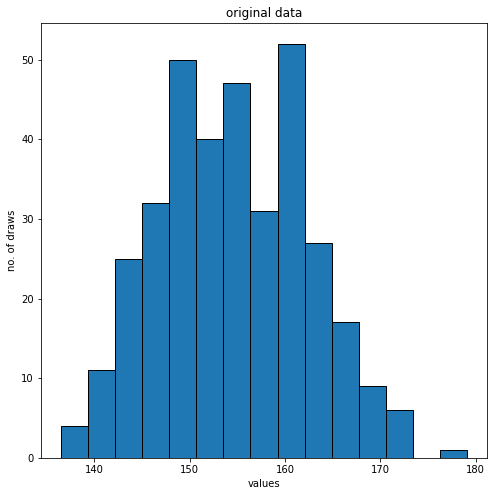

In [45]:
plt.figure(figsize = (8, 8))
plt.hist(d.iloc[:, 0], bins = 15, edgecolor='k')
plt.title("original data")
plt.xlabel("values")
plt.ylabel("no. of draws")
plt.show()

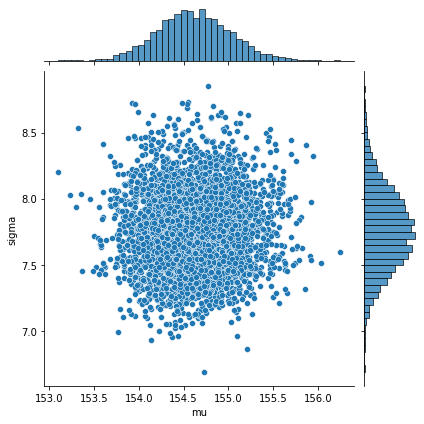

In [28]:
jointplot(data = data, x = "mu", y = "sigma")

#### Task 2. Model fit and evaluation

1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.



### Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substracted by their mean.


In [ ]:
# weight - mean of the weight

In [75]:
d['c_weight'] = d['weight']/np.mean(d['weight'])
d

,height,weight,age,male,c_weight
0,151.765,47.825606,63.0,1,1.063016
1,139.700,36.485807,63.0,0,0.810967
2,136.525,31.864838,65.0,0,0.708257
3,156.845,53.041914,41.0,1,1.178958
4,145.415,41.276872,51.0,0,0.917458
...,...,...,...,...,...
534,162.560,47.031821,27.0,0,1.045373
537,142.875,34.246196,31.0,0,0.761188
540,162.560,52.163080,31.0,1,1.159425
541,156.210,54.062497,21.0,0,1.201643


In [86]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max(), 50)}
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [83]:
data2 = sim.draws_pd()
data2

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[40],height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49]
0,0.0,0.0,232.163,7.771810,23.208300,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249.666
1,0.0,0.0,190.873,-11.989200,0.114332,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174.075
2,0.0,0.0,204.088,-0.758924,8.136610,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,211.122
3,0.0,0.0,186.980,-0.398653,3.234260,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184.872
4,0.0,0.0,195.853,-4.788490,3.169160,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,188.713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,177.117,-4.678640,3.671560,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,166.746
996,0.0,0.0,189.097,17.242700,1.190430,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,211.731
997,0.0,0.0,198.269,-6.332260,1.633310,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.618
998,0.0,0.0,181.211,-12.081100,8.202720,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,165.836


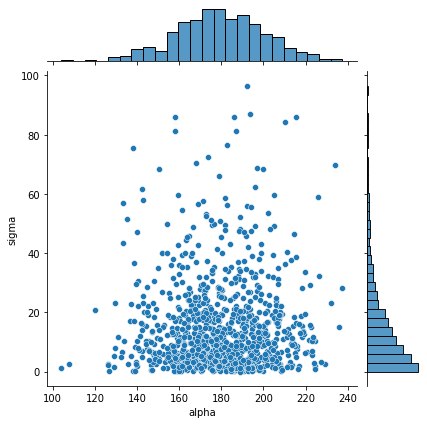

In [88]:
jointplot(data = data2, x = "alpha", y = "sigma")
plt.show()

#### Task 4. Prior predictive checks
1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

### Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [89]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [90]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [91]:
data4 = sim.draws_pd()
data4

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,232.163,2.175330,23.208300,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250.147
1,0.0,0.0,154.022,0.993243,0.086958,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.406
2,0.0,0.0,169.461,0.320255,20.358900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174.255
3,0.0,0.0,158.357,0.775342,6.415610,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,157.156
4,0.0,0.0,158.131,5.317560,9.955320,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,157.475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,161.753,3.529990,6.017940,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.627
996,0.0,0.0,196.362,3.398650,10.413300,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,199.145
997,0.0,0.0,172.792,0.761815,76.805200,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.557
998,0.0,0.0,126.115,2.683600,23.204300,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134.869


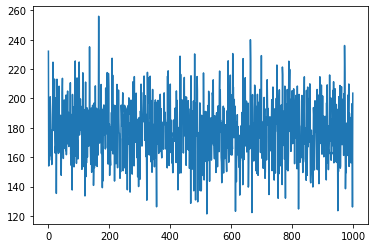

In [96]:
plt.plot(data4['alpha'])
plt.show()

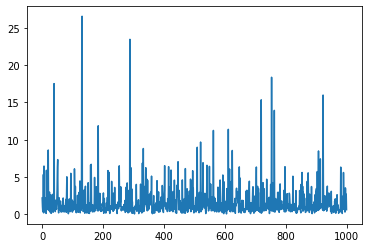

In [94]:
plt.plot(data4['beta'])
plt.show()

On the Wikipedia there is no information about height and weight of !Knug people, can't confirm credibility of resulted data, but height at the level of > 250 [cm] is not very beliveable

#### Task 5. Prior predictive checks
1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

### Fitting data


In [97]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


#### Task 6. Preparing data for fit
1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe

In [118]:
data_fit = {
    "N": 100, 
    "weight": d['weight'][0:100],
    "heights": d['height'][0:100]
}

fit=model_2_fit.sample(data=data_fit,seed=28052020)


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |█████████ | 00:01 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [119]:
data6 = fit.draws_pd()
data6

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,sigma,...,height[91],height[92],height[93],height[94],height[95],height[96],height[97],height[98],height[99],height[100]
0,-228.432,0.913122,0.104094,5.0,31.0,0.0,229.792,119.083,0.751989,5.41972,...,154.540,155.951,159.244,163.271,144.622,163.432,146.376,156.758,141.968,157.568
1,-225.906,1.000000,0.104094,2.0,3.0,0.0,228.403,120.067,0.761550,5.40665,...,155.327,164.043,157.375,155.903,149.722,154.039,155.632,165.763,156.296,152.437
2,-225.007,0.897749,0.104094,5.0,31.0,0.0,227.196,110.801,0.976445,5.42328,...,156.596,165.604,168.279,150.175,152.895,166.580,150.965,162.464,161.760,152.937
3,-225.030,0.883446,0.104094,2.0,3.0,0.0,226.447,109.941,0.963991,5.37142,...,165.332,156.442,156.268,165.511,150.293,166.170,149.561,160.900,171.906,154.262
4,-225.106,0.989123,0.104094,4.0,31.0,0.0,230.475,110.409,0.978283,5.91544,...,153.124,170.409,159.683,155.020,156.303,160.071,149.017,161.514,167.931,154.598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-226.634,0.995978,0.133125,4.0,23.0,0.0,227.886,104.729,1.086420,5.40149,...,156.503,154.618,148.283,160.487,147.124,160.754,149.447,149.668,157.583,153.011
3996,-224.594,0.981333,0.133125,5.0,47.0,0.0,227.107,116.112,0.835909,5.42705,...,152.861,154.838,157.350,163.707,145.057,155.003,153.627,168.266,158.537,140.322
3997,-226.693,0.720502,0.133125,2.0,3.0,0.0,226.846,115.709,0.827389,5.45402,...,152.709,163.597,154.020,157.883,162.151,151.464,151.680,152.678,153.024,156.039
3998,-225.549,0.980910,0.133125,5.0,31.0,0.0,229.891,107.784,1.014730,5.21322,...,163.573,166.727,148.194,158.103,155.506,163.878,145.524,169.630,161.865,153.754


In [124]:
data6.iloc[:, 10]

0       155.047
1       156.489
2       157.500
3       156.045
4       157.196
         ...   
3995    156.687
3996    156.090
3997    155.279
3998    156.314
3999    155.752
Name: mu[1], Length: 4000, dtype: float64

#### Task 7. Evaluating model

1. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


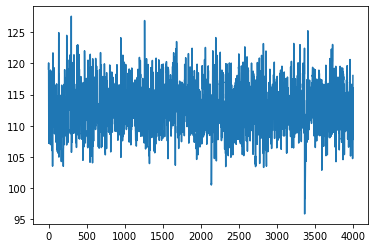

In [120]:
plt.plot(data6['alpha'])
plt.show()

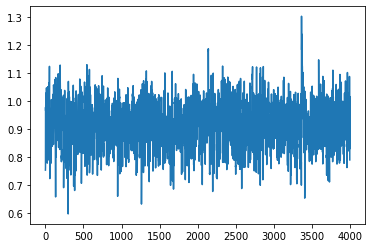

In [121]:
plt.plot(data6['beta'])
plt.show()

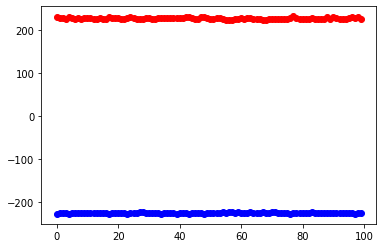

In [138]:
plt.figure(10)
for i in range(100):
    plt.plot(i, np.min(data6.iloc[i+10]), color='blue', marker='o')
    plt.plot(i, np.max(data6.iloc[i+10]), color='red', marker='o')
plt.show()